##### Imports

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
import seaborn as sns
import scipy.optimize
from IPython.display import display, Markdown

In [111]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

## Synthetic data

In [112]:
# TODO add a final completely random rotation element (same across whole
# measurement sequence) to represent the fact that we don't know where
# gravity is pointing relative to the sensor


def generate_stationary_noise(length):
    """Generate random normally distributed accelerometer measurements
    representing the noise experienced by a stationary sensor."""
    return np.random.normal(0, 1, (length, 3))


#def generate_linear_data(length):
#    """Generate normally distributed random data representing linear
#    acceleration along a vector, like a dumbbell squat."""
#    # TODO this doesn't look right
#    movement_vector = (np.random.random(3) - 0.5) * 2
#    movement_vectors = np.tile(movement_vector, (length, 1))
#    random_scalars = np.random.normal(0, 1, length)
#    angular_v = movement_vectors * random_scalars[:, None]
#    return angular_v

def generate_linear_data(length):
    pass


def generate_circular_data(length, radius=1, angle=2 * np.pi):
    """Generate acceleration data representing 2D circular motion,
    like a dumbbell curl."""
    # TODO also add the rising edge of the exercise

    # Generate x and y coordinates of an arc segment (no z yet)
    angular_v = np.zeros((length, 3))
    angular_v[:, 0] = radius * np.cos(np.linspace(0, angle, length))
    angular_v[:, 1] = radius * np.sin(np.linspace(0, angle, length))

    # Do some rotations to simulate the motion of a dumbbell curl
    # Rotate 0.53pi radians about z counterclockwise
    theta_z = -0.53 * np.pi
    R_z = np.array(
        [
            [np.cos(theta_z), -np.sin(theta_z), 1],
            [np.sin(theta_z), np.cos(theta_z), 0],
            [0, 0, 1],
        ]
    )

    # Flip about y
    theta_y = -np.pi
    R_y = np.array(
        [
            [np.cos(theta_y), 0, np.sin(theta_y)],
            [0, 1, 0],
            [-np.sin(theta_y), 0, np.cos(theta_y)],
        ]
    )

    R = np.dot(R_z, R_y)
    angular_v = np.dot(angular_v, R)

    return angular_v

### Synthetic dumbbell curl

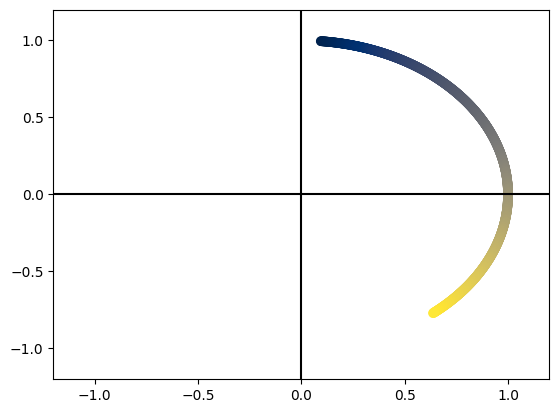

In [113]:
curl_down = generate_circular_data(1000, angle=0.75*np.pi)

# Four-quadrant XY plot
# Plot points in scatter wiht changing colour to indicate direction
plt.scatter(curl_down[:, 0], curl_down[:, 1], c=np.linspace(0, 1, len(curl_down)), cmap="cividis")
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.axvline(0, color="black")
plt.axhline(0, color="black")
plt.show()

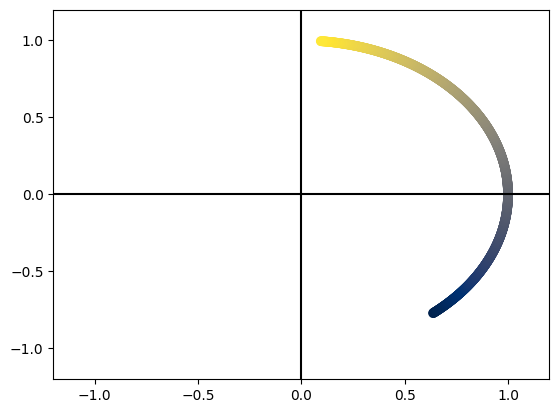

In [114]:
curl_up = curl_down[::-1, :]

# Four-quadrant XY plot
# Plot points in scatter wiht changing colour to indicate direction
plt.scatter(curl_up[:, 0], curl_up[:, 1], c=np.linspace(0, 1, len(curl_up)), cmap="cividis")
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.axvline(0, color="black")
plt.axhline(0, color="black")
plt.show()

### Synthetic squat

# Experiment

## Load data

In [115]:
curls_df = pd.read_csv("./data/sam/Curls_3x10_7kg-2024-01-25_16-55-30/TotalAcceleration.csv")
squat_df = pd.read_csv("./data/sam/Squats_3x8_7kg-2024-01-25_17-00-38/TotalAcceleration.csv")
curls_df

,time,seconds_elapsed,y,z,x,hypothesis
0,1.706202e+18,0.252757,-7.177817,6.464345,0.991199,NaN
1,1.706202e+18,0.274439,-7.551312,6.133945,1.216254,NaN
2,1.706202e+18,0.290274,-7.771579,5.315128,1.273715,NaN
3,1.706202e+18,0.306591,-8.087613,5.238513,0.900220,NaN
4,1.706202e+18,0.316342,-8.240842,5.722142,1.297657,NaN
...,...,...,...,...,...,...
3308,1.706202e+18,36.236247,1.015141,7.556100,7.144298,NaN
3309,1.706202e+18,36.246292,0.588974,7.513005,7.407660,NaN
3310,1.706202e+18,36.256083,0.378284,7.235278,6.971915,NaN
3311,1.706202e+18,36.266168,0.756568,7.163452,6.296751,NaN


## Trim data to relevant periods

Data is trimmed so that it starts at the beginning of the first rep and ends at the end of the last rep.

|Exercise|Reps|Weight|
|-|-|-|
|Curls|10|7kg dumbbells|
|Squats|8|7kg dumbbells|

In [116]:
# Plot x, y and z values on a line for curl_df
def plot_accelerometer(df):
    fig = plt.figure(figsize=(50, 5))  
    plt.subplot(1, 3, 1)
    plt.ylabel("Accelerometer $m/s^2$")
    plt.xlabel("Time elapsed (s)")
    plt.plot(df["seconds_elapsed"], df["x"], label="x")
    plt.plot(df["seconds_elapsed"], df["y"], label="y")
    ax = plt.plot(df["seconds_elapsed"], df["z"], label="z")

def plot_accelerometer_hyp(df):
    fig = plt.figure(figsize=(50, 5))  
    plt.subplot(1, 3, 1)
    plt.ylabel("Accelerometer $m/s^2$")
    plt.xlabel("Time elapsed (s)")
    plt.plot(df["seconds_elapsed"], df["x"], label="x")
    plt.plot(df["seconds_elapsed"], df["y"], label="y")
    ax = plt.plot(df["seconds_elapsed"], df["z"], label="z")

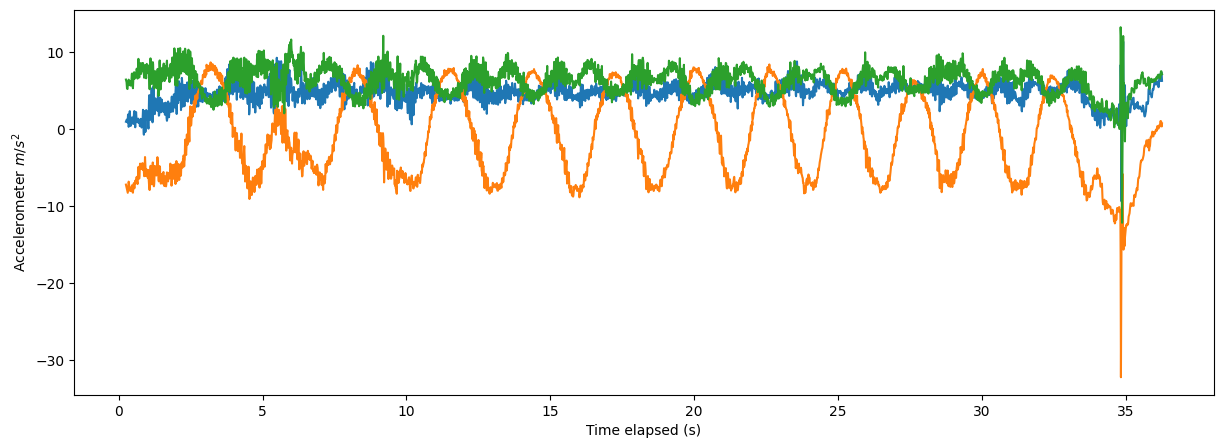

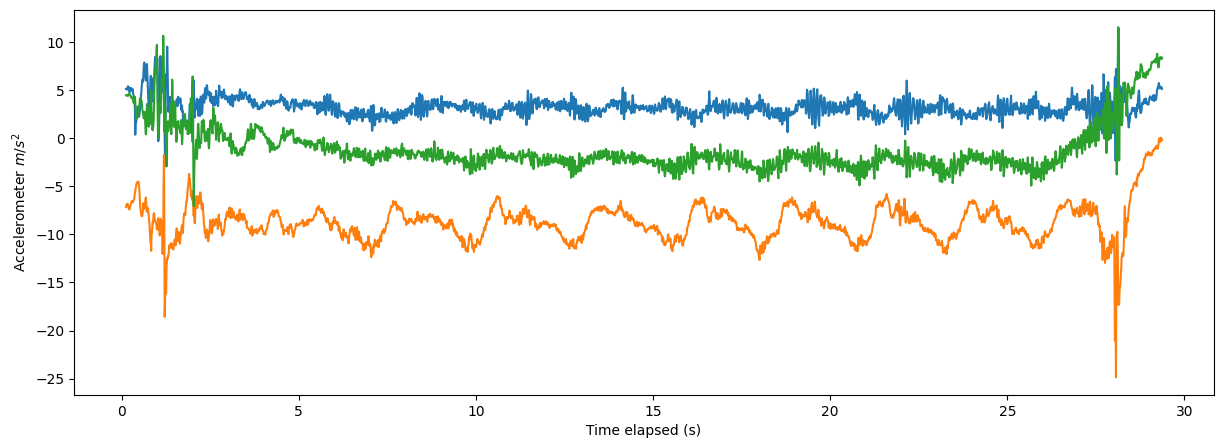

In [117]:
plot_accelerometer(curls_df)
plot_accelerometer(squat_df)

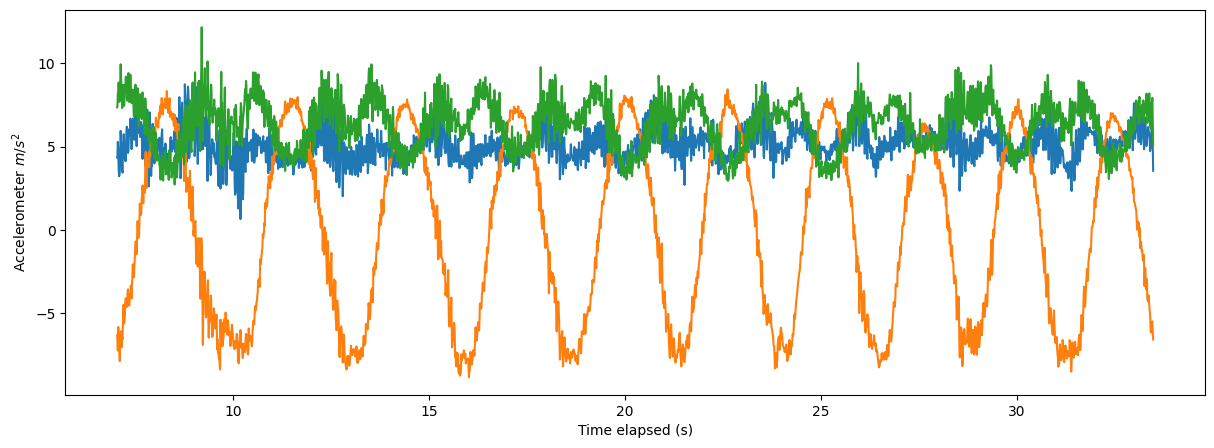

In [118]:
# Trim curls to remove the picking up of weights at the beginning of
# the set and the putting down at the end of the set
curls_df_start = curls_df[curls_df["seconds_elapsed"] == 7.0367890625].index[0]
curls_df_end = curls_df[curls_df["seconds_elapsed"] == 33.48751904296875].index[0]
curls_df_trim = curls_df.iloc[curls_df_start:curls_df_end, :]
plot_accelerometer(curls_df_trim)

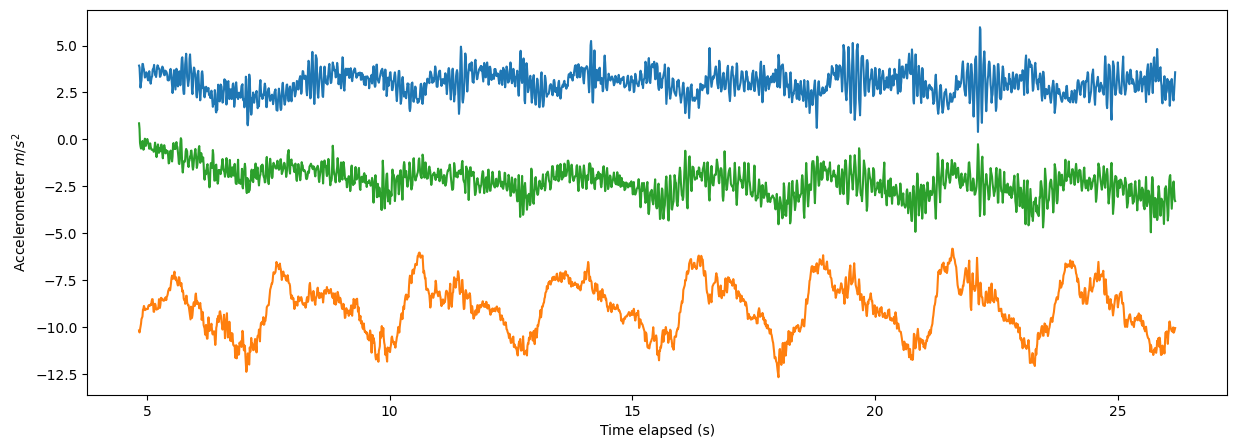

In [119]:
# Trim squats to remove the picking up of weights at the beginning of
# the set and the putting down at the end of the set
squat_df_start = squat_df[squat_df["seconds_elapsed"] == 4.837999267578125].index[0] #4.83
squat_df_end = squat_df[squat_df["seconds_elapsed"] == 26.19851220703125].index[0] #26.19
squat_df_trim = squat_df.iloc[squat_df_start:squat_df_end, :]
plot_accelerometer(squat_df_trim)

## Label data

Periods in the data representing certain motions are manually marked with the appropriate hypothesis.

|Exercise|Part|Hypothesis|
|-|-|-|
|Curls|Raising movement|$\mathcal{H}_0$|
|Curls|Lowering movement|$\mathcal{H}_0$|
|Curls|Motionless period between reps|$\mathcal{H}_0$|
|Squats|Raising movement|$\mathcal{H}_1$|
|Squats|Lowering movement|$\mathcal{H}_1$|
|Squats|Motionless period between reps|$\mathcal{H}_0$|

### Set true hypotheses on trimmed data

#### Curls

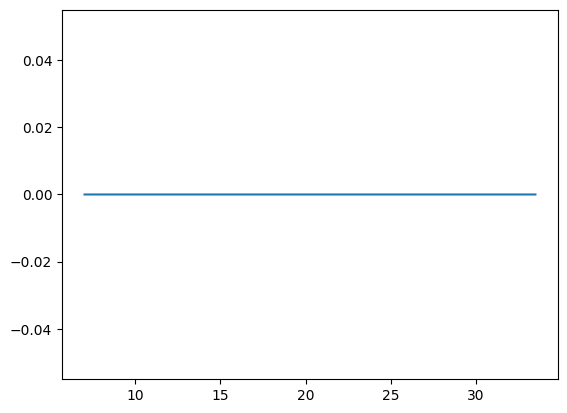

In [120]:
curls_df_trim.loc[:, 'hypothesis'] = 0
ax = plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["hypothesis"])

#### Squats
Is this all just totally fucked? Do I need to pick other exercises? This doesnt seem rigorous or right at all

In [121]:
squat_df_trim["seconds_elapsed"] >= 0

464     True
465     True
466     True
467     True
468     True
        ... 
2389    True
2390    True
2391    True
2392    True
2393    True
Name: seconds_elapsed, Length: 1930, dtype: bool

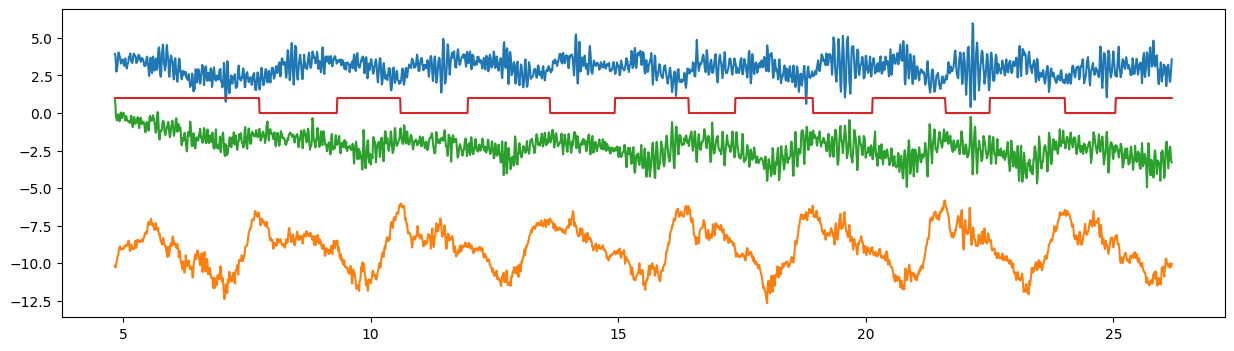

In [141]:
# Motionless end   - idx 0
# Bottom of rep 1  - 7.03787s - H1 - 7.037873779296875
# Top of rep 1     - 7.75819s - H1 - 7.75818505859375
# Motionless end 1 - 9.32852s - H0 - 9.328517822265624
# Bottom of rep 2  - 9.76746s - H1 - 9.7674619140625
# Top of rep 2     - 10.5975s - H1 - 10.597513916015625
# Motionless end 2 - 11.9576s - H0 - 11.957637939453125
# Bottom of rep 3  - 12.7275s - H1 - 12.727472900390625
# Top of rep 3     - 13.618s  - H1 - 13.618012939453125
# Motionless end 3 - 14.9384s - H0 - 14.93835205078125
# Bottom of rep 4  - 15.8475s - H1 - 15.8475068359375
# Top of rep 4     - 16.4283s - H1 - 16.428326904296874
# Motionless end 4 - 17.368s  - H0 - 17.36797705078125
# Bottom of rep 5  - 18.2379s - H1 - 18.237943115234376
# Top of rep 5     - 18.938s  - H1 - 18.938011962890624
# Motionless end 5 - 20.1391s - H0 - 20.139137939453125
# Bottom of rep 6  - 21.0387s - H1 - 21.03868115234375
# Top of rep 6     - 21.6189s - H1 - 21.618908935546877
# Motionless end 6 - 22.5000s - H0 - 22.507530029296873
# Bottom of rep 6  - 23.2380s - H1 - 23.2380419921875
# Top of rep 7     - 24.0281s - H1 - 24.028087158203125
# Motionless end 7 - 25.0486s - H0 - 25.048609130859376
# Bottom of rep 8  - 25.7177s - H1 - 25.71772119140625
# Top of rep 8     - 26.7175s - H1 - 26.717465087890623
# Motionless end 8 - 27.5377s - H0 - 27.537717041015625

conds = [
    (squat_df_trim["seconds_elapsed"] >= 0.0)                & (squat_df_trim["seconds_elapsed"] < 7.037873779296875),
    (squat_df_trim["seconds_elapsed"] >= 7.037873779296875) & (squat_df_trim["seconds_elapsed"] < 7.75818505859375),
    (squat_df_trim["seconds_elapsed"] >= 7.75818505859375) & (squat_df_trim["seconds_elapsed"] < 9.328517822265624),
    (squat_df_trim["seconds_elapsed"] >= 9.328517822265624) & (squat_df_trim["seconds_elapsed"] < 9.7674619140625),
    (squat_df_trim["seconds_elapsed"] >= 9.7674619140625) & (squat_df_trim["seconds_elapsed"] < 10.597513916015625),
    (squat_df_trim["seconds_elapsed"] >= 10.597513916015625) & (squat_df_trim["seconds_elapsed"] < 11.957637939453125),
    (squat_df_trim["seconds_elapsed"] >= 11.957637939453125) & (squat_df_trim["seconds_elapsed"] < 12.727472900390625),
    (squat_df_trim["seconds_elapsed"] >= 12.727472900390625) & (squat_df_trim["seconds_elapsed"] < 13.618012939453125),
    (squat_df_trim["seconds_elapsed"] >= 13.618012939453125) & (squat_df_trim["seconds_elapsed"] < 14.93835205078125),
    (squat_df_trim["seconds_elapsed"] >= 14.93835205078125) & (squat_df_trim["seconds_elapsed"] < 15.8475068359375),
    (squat_df_trim["seconds_elapsed"] >= 15.8475068359375) & (squat_df_trim["seconds_elapsed"] < 16.428326904296874),
    (squat_df_trim["seconds_elapsed"] >= 16.428326904296874) & (squat_df_trim["seconds_elapsed"] < 17.36797705078125),
    (squat_df_trim["seconds_elapsed"] >= 17.36797705078125) & (squat_df_trim["seconds_elapsed"] < 18.237943115234376),
    (squat_df_trim["seconds_elapsed"] >= 18.237943115234376) & (squat_df_trim["seconds_elapsed"] < 18.938011962890624),
    (squat_df_trim["seconds_elapsed"] >= 18.938011962890624) & (squat_df_trim["seconds_elapsed"] < 20.139137939453125),
    (squat_df_trim["seconds_elapsed"] >= 20.139137939453125) & (squat_df_trim["seconds_elapsed"] < 21.03868115234375),
    (squat_df_trim["seconds_elapsed"] >= 21.03868115234375) & (squat_df_trim["seconds_elapsed"] < 21.618908935546877),
    (squat_df_trim["seconds_elapsed"] >= 21.618908935546877) & (squat_df_trim["seconds_elapsed"] < 22.507530029296873),
    (squat_df_trim["seconds_elapsed"] >= 22.507530029296873) & (squat_df_trim["seconds_elapsed"] < 23.2380419921875),
    (squat_df_trim["seconds_elapsed"] >= 23.2380419921875)& (squat_df_trim["seconds_elapsed"] < 24.028087158203125),
    (squat_df_trim["seconds_elapsed"] >= 24.028087158203125) & (squat_df_trim["seconds_elapsed"] < 25.048609130859376),
    (squat_df_trim["seconds_elapsed"] >= 25.048609130859376) & (squat_df_trim["seconds_elapsed"] < 25.71772119140625),
    (squat_df_trim["seconds_elapsed"] >= 25.71772119140625) & (squat_df_trim["seconds_elapsed"] < 26.717465087890623),
    (squat_df_trim["seconds_elapsed"] >= 26.717465087890623) & (squat_df_trim["seconds_elapsed"] < 27.537717041015625),
]

values = [1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0]
true_hyps = np.select(conds, values)
squat_df_trim.loc[:, 'hypothesis'] = true_hyps

# Plot accelerometer data and hypothesis on the same graph
plt.figure(figsize=(15, 4))
plt.plot(squat_df_trim["seconds_elapsed"], squat_df_trim["x"], label="x")
plt.plot(squat_df_trim["seconds_elapsed"], squat_df_trim["y"], label="y")
plt.plot(squat_df_trim["seconds_elapsed"], squat_df_trim["z"], label="z")
ax = plt.plot(squat_df_trim["seconds_elapsed"], np.select(conds, values), label="hypothesis")

## Compute test statistics for data

In [123]:
def SSM(vector):
    """ Skew-symmetric vector such that something something (TODO) """
    return np.array(
        [
            [0, -vector[2], vector[1]],
            [vector[2], 0, -vector[1]],
            [vector[1], vector[0], 0],
        ]
    )


def compute_test_statistics(measurements):
    Ts = []

    for measurement in measurements:
        M = SSM(measurement).T * SSM(measurement)
        eigs, _ = np.linalg.eig(M)
        min_eig = min(eigs)
        Ts.append(min_eig)

    return np.array(Ts)

### Test statistics on random data

In [124]:
# Compute test statistics for randomly generated values
measurements = np.random.rand(1000, 3)

Ts = compute_test_statistics(measurements)

### Test statistics on real data

In [125]:
# Curls
Ts_curls = compute_test_statistics(curls_df_trim[["x", "y", "z"]].to_numpy())
Ts_curls

array([ -81.83912711,  -85.90894082, -105.64727821, ...,  -84.97330927,
        -74.0806646 ,  -62.53904938])

In [126]:
#Squats
Ts_squat = compute_test_statistics(squat_df_trim[["x", "y", "z"]].to_numpy())
pd.Series(Ts_squat).describe()

count    1930.000000
mean      -89.262420
std        26.116771
min      -177.519589
25%      -107.698710
50%       -85.939415
75%       -70.078111
max       -36.354081
dtype: float64

## Select threshold value $\gamma$ with best accuracy

In [127]:
def decide_on_hypothesis(test_statistics, gamma):
    """Decide on hypothesis at each point."""
    return test_statistics > gamma

def evaluate_decisions(decisions, true_hyps):
    """Calculate the proportion of decisions that were correct."""
    return np.mean(decisions == true_hyps)

def calculate_error(decisions, true_hyps):
    return np.mean(decisions != true_hyps)

def plot_hypotheses(x, hypotheses, s=None):
    plt.xlabel("Seconds elapsed (s)")
    plt.ylabel("Hypothesis")
    plt.yticks([0, 1])
    plt.ylim(-0.1, 1.1)
    ax = plt.scatter(x, hypotheses, s=s)
    return ax

### Grid search

### Minimum accuracy: 0.23523316062176167

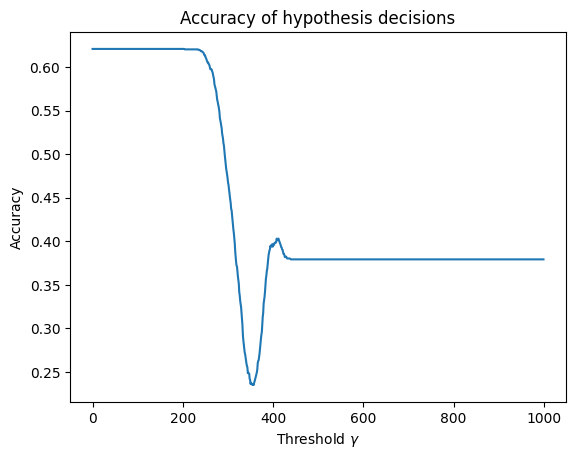

In [153]:
# Grid search threshold
gammas = np.linspace(-300, 300, 1000)

# Select the threshold that yields the best accuracy
hypotheses = [decide_on_hypothesis(Ts_squat, gamma) for gamma in gammas]
acc_grid = pd.Series(
    [
        evaluate_decisions(decisions, squat_df_trim["hypothesis"])
        for decisions in hypotheses
    ]
)
plt.title("Accuracy of hypothesis decisions")
plt.xlabel("Threshold $\gamma$")
plt.ylabel("Accuracy")
ax = acc_grid.plot()
display(Markdown(f"### Minimum accuracy: {acc_grid.min()}"))

Grid search shows the "best" $\gamma$ to be around $-53.75$.

In [129]:
def side_by_side_hyps(x, y1, y2, left, right):
    """Plot two sets of hypotheses side by side."""
    plt.figure(figsize=(15, 4))

    plt.subplot(2, 1, 1)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.xticks(np.arange(left, right, 1))
    plt.grid(axis="x", linestyle="--")
    ax1 = plt.scatter(x, y1, s=1)

    plt.subplot(2, 1, 2)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.xticks(np.arange(left, right, 1))
    plt.grid(axis="x", linestyle="--")
    ax2 = plt.scatter(x, y2, s=1)
    return ax1, ax2

Accuracy: 0.23523316062176167


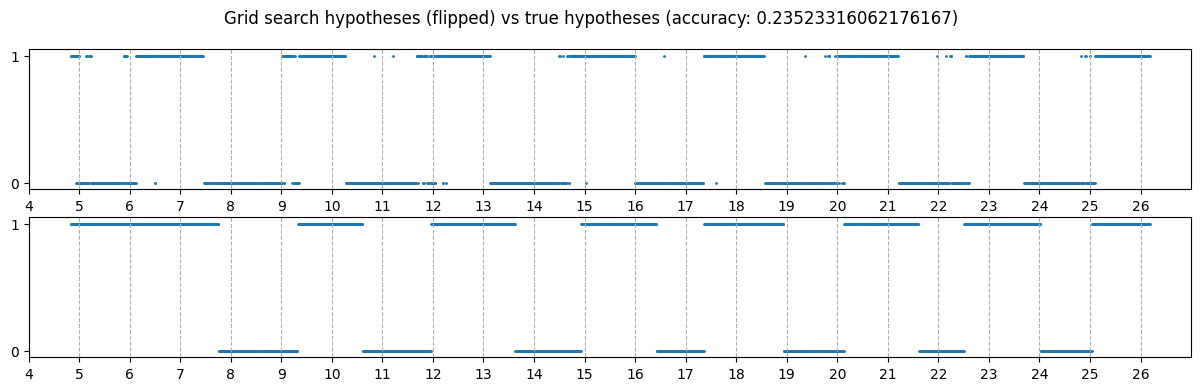

In [154]:
# Plot the best hypotheses by grid search
best_hypotheses_grid = hypotheses[acc_grid.idxmin()]
print(f"Accuracy: {evaluate_decisions(best_hypotheses_grid, squat_df_trim['hypothesis'])}")
ax1, ax2 = side_by_side_hyps(
    squat_df_trim["seconds_elapsed"],
    ~best_hypotheses_grid, # flipped
    squat_df_trim["hypothesis"],
    4,
    27,
)
t = plt.suptitle(f"Grid search hypotheses (flipped) vs true hypotheses (accuracy: {evaluate_decisions(best_hypotheses_grid, squat_df_trim['hypothesis'])})")

$\uparrow$ Hypothesis list too long? Plotting wrong?

In [131]:
print(len(best_hypotheses_grid))
print(len(squat_df_trim["hypothesis"].dropna()))

1930
1930


### Scipy optimisers

In [132]:
# Hypotheses for initial conditions
hypotheses_400 = decide_on_hypothesis(Ts_squat, 400)

### NONSENSE below this point (optimisation done wrong)

In [133]:
opt1 = scipy.optimize.minimize(
    calculate_error,
    x0=hypotheses_400,
    args=(squat_df_trim["hypothesis"],),
    method="Powell",
)
opt1

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.0
       x: [ 1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 126448

$\uparrow$ **TODO** How do I extract $\gamma$? $\uparrow$

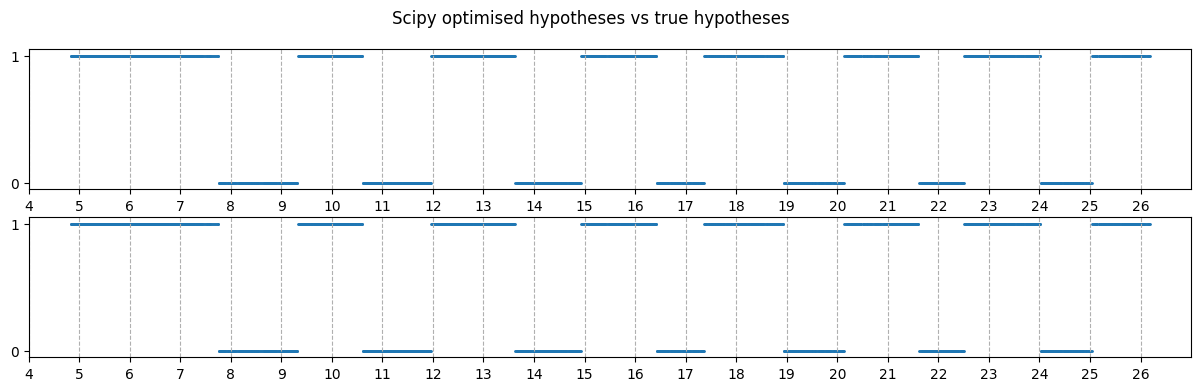

In [134]:
ax1, ax2 = side_by_side_hyps(squat_df_trim["seconds_elapsed"], opt1["x"], squat_df_trim["hypothesis"], 4, 27)
t = plt.suptitle("Scipy optimised hypotheses vs true hypotheses")

In [135]:
# Accuracy
np.mean(opt1["x"] == squat_df_trim["hypothesis"])

1.0

In [136]:
print(len(hypotheses_400))
print(len(squat_df_trim["hypothesis"]))

1930
1930
